In [1]:
import sys

import numpy as np

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from torch.nn.functional import avg_pool2d, interpolate

import config as c
import opts
import data

In [2]:
#opts.parse(sys.argv)
print('==='*30)
print('Config options:\n')
for v in dir(c):

    if v[0]=='_': continue
    s=eval('c.%s'%(v))
    print('  {:25}\t{}'.format(v,s))

print('==='*30)

Config options:

  add_image_noise          	0.15
  batch_size               	512
  betas                    	(0.9, 0.999)
  checkpoint_on_error      	True
  checkpoint_save_interval 	360
  checkpoint_save_overwrite	True
  clamping                 	1.9
  colorize                 	False
  cond_net_file            	
  cond_width               	64
  data_mean                	0.0
  data_std                 	1.0
  decay_by                 	0.01
  do_fwd                   	True
  do_rev                   	False
  fc_dropout               	0.0
  filename                 	output/luc_saving_mnist_cinn.pt
  img_dims                 	(28, 28)
  init_scale               	0.03
  internal_width           	256
  internal_width_conv      	64
  live_visualization       	False
  load_file                	output/checkpoint.pt
  loss_names               	['L', 'L_rev']
  lr                       	0.0001
  n_blocks                 	7
  n_blocks_conv            	3
  n_epochs                 	1440
  n_its_pe

In [3]:
import model

In [4]:
model.load(c.filename)

In [5]:
model.model.eval()

ReversibleGraphNet(
  (module_list): ModuleList(
    (0): None
    (1): deprecated_class()
    (2): deprecated_class()
    (3): deprecated_class(
      (s1): F_fully_connected(
        (d1): Dropout(p=0.0, inplace=False)
        (d2): Dropout(p=0.0, inplace=False)
        (d2b): Dropout(p=0.0, inplace=False)
        (fc1): Linear(in_features=402, out_features=256, bias=True)
        (fc2): Linear(in_features=256, out_features=256, bias=True)
        (fc2b): Linear(in_features=256, out_features=256, bias=True)
        (fc3): Linear(in_features=256, out_features=784, bias=True)
        (nl1): ReLU()
        (nl2): ReLU()
        (nl2b): ReLU()
      )
      (s2): F_fully_connected(
        (d1): Dropout(p=0.0, inplace=False)
        (d2): Dropout(p=0.0, inplace=False)
        (d2b): Dropout(p=0.0, inplace=False)
        (fc1): Linear(in_features=402, out_features=256, bias=True)
        (fc2): Linear(in_features=256, out_features=256, bias=True)
        (fc2b): Linear(in_features=256, ou

In [6]:
test_labels = torch.LongTensor((list(range(10))*(c.batch_size//10 + 1))[:c.batch_size]).cuda()
test_cond = torch.zeros(c.batch_size, model.cond_size).cuda()
test_cond.scatter_(1, test_labels.view(-1,1), 1.)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [7]:
def img_tile(imgs, row_col = None, transpose = False, channel_first=True, channels=3):
    '''tile a list of images to a large grid.
    imgs:       iterable of images to use
    row_col:    None (automatic), or tuple of (#rows, #columns)
    transpose:  Wheter to stitch the list of images row-first or column-first
    channel_first: if true, assume images with CxWxH, else WxHxC
    channels:   3 or 1, number of color channels '''
    if row_col == None:
        sqrt = np.sqrt(len(imgs))
        rows = np.floor(sqrt)
        delt = sqrt - rows
        cols = np.ceil(rows + 2*delt + delt**2 / rows)
        rows, cols = int(rows), int(cols)
    else:
        rows, cols = row_col

    if channel_first:
        h, w = imgs[0].shape[1], imgs[0].shape[2]
    else:
        h, w = imgs[0].shape[0], imgs[0].shape[1]

    show_im = np.zeros((rows*h, cols*w, channels))

    if transpose:
        def iterator():
            for i in range(rows):
                for j in range(cols):
                    yield i, j

    else:
        def iterator():
            for j in range(cols):
                for i in range(rows):
                    yield i, j

    k = 0
    for i, j in iterator():

            im = imgs[k]
            if channel_first:
                im = np.transpose(im, (1, 2, 0))

            show_im[h*i:h*i+h, w*j:w*j+w] = im

            k += 1
            if k == len(imgs):
                break

    return np.squeeze(show_im)

def sample_outputs(sigma):
    '''Produce a random latent vector with sampling temperature sigma'''
    return sigma * torch.randn(c.batch_size, c.output_dim).cuda()

def show_training_data(digit, n_imgs, save_as=None):
    '''Show some validation images (if you want to look for interesting examples etc.)
    digit:      int 0-9, show images of this digit
    n_imgs:     show this many images
    save_as:    None, or filename, to save the image file'''
    imgs = []
    while len(imgs) < n_imgs ** 2:
        color, label, img = next(iter(data.train_loader))
        imgs += list(color[label==digit])

    img_show = img_tile(imgs, (n_imgs, n_imgs))
    plt.figure()
    plt.imshow(img_show)
    if save_as:
        plt.imsave(save_as,  img_show)


 ## cINN with conditioning network for colorization of 'color MNIST' 


In [8]:
c.colorize

False

100%|██████████| 256/256 [00:04<00:00, 56.20it/s]


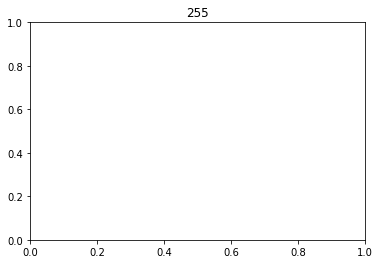

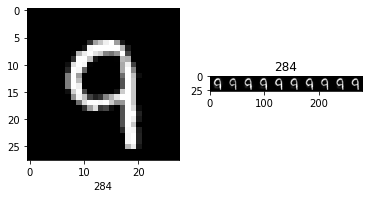

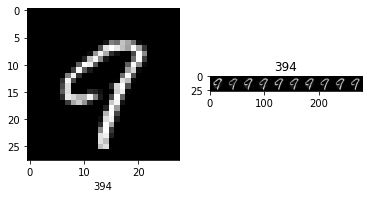

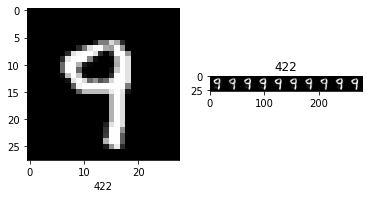

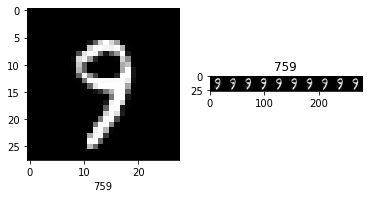

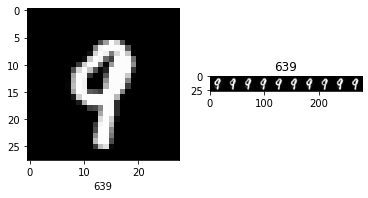

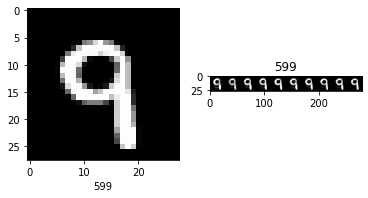

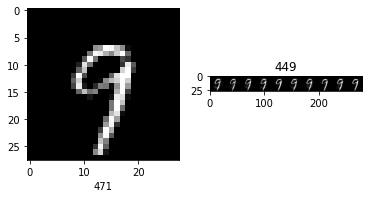

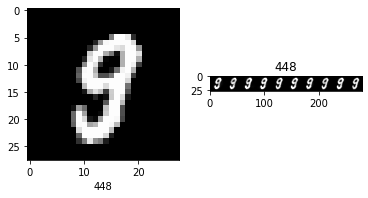

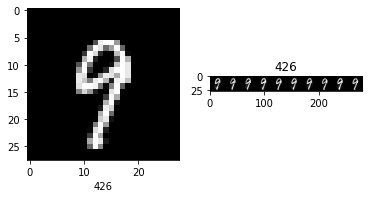

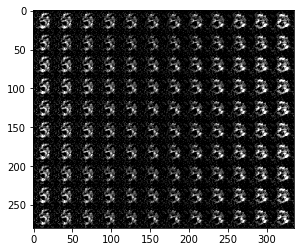

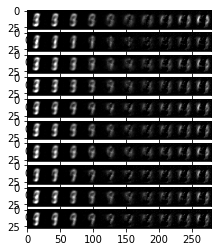

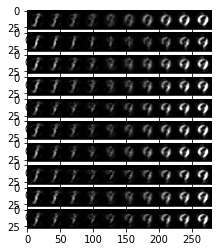

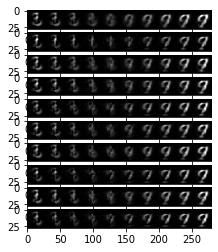

In [9]:
if c.colorize:
    def color_single(bw_img, n_show=11, save_as=None, subplot_args=None):
        '''colorize a sinlge black-and-white image.
        bw_img:     1x28x28 bw image
        n_show:     how many samples to generate
        save_as:    if not None: save image filename
        subplot_args:   If not None: use plt.sublot(*subplot_args) instead of plt.figure()'''

        with torch.no_grad():
            cond_features = cond_net.model.features(bw_img.expand(c.batch_size, -1, -1, -1))
            cond = torch.cat([bw_img.expand(c.batch_size, 1, *c.img_dims),
                              cond_features.view(c.batch_size, c.cond_width, 1, 1).expand(-1, -1, *c.img_dims)], dim=1)

        z = sample_outputs(1.0)

        with torch.no_grad():
            colored = data.unnormalize(model.model(z, cond, rev=True)[:n_show].data.cpu().numpy())

        imgs = [torch.cat([bw_img]*3, 0).cpu().numpy()]
        imgs += list(colored)

        img_show = img_tile(imgs, (1, n_show+1))
        img_show = np.clip(img_show, 0, 1)

        if subplot_args:
            plt.subplot(*subplot_args)
        else:
            plt.figure()

        plt.imshow(img_show)
        plt.xticks([])
        plt.yticks([])
        if save_as:
            plt.imsave(save_as,  img_show)


    torch.manual_seed(0)
    import data
    import cond_net

    color, label, img = next(iter(data.train_loader))
    color, label, img = color.cuda(), label.cuda(), img.cuda()

    # make a large figure comparing the colorizaton of more and less ambiguous bw images:
    plt.figure()
    indx_examples = list([16, 17, 18, 19, 20])

    for i, n in enumerate(indx_examples):
        color_single(img[n], subplot_args=(len(indx_examples), 1, i+1))

    plt.savefig('colors.png', dpi=300)

########################################################################
#    Standard cINN for class-conditional generation of MNIST images    #
########################################################################
else:
    def interpolation(temp=1., n_steps=12, seeds=None, save_as=None):
        '''Interpolate between to random latent vectors.
        temp:       Sampling temperature
        n_steps:    Interpolation steps
        seeds:      Optional 2-tuple of seeds for the two random latent vectors
        save_as:    Optional filename to save the image.'''

        if seeds is not None:
            torch.manual_seed(seeds[0])

        z_sample_0 = sample_outputs(temp)
        z_0 = z_sample_0[0].expand_as(z_sample_0)

        if seeds is not None:
            torch.manual_seed(seeds[1])

        z_sample_1 = sample_outputs(temp)
        z_1 = z_sample_1[1].expand_as(z_sample_1)

        interpolation_steps = np.linspace(0., 1., n_steps, endpoint=True)
        interp_imgs = []

        for t in interpolation_steps:
            with torch.no_grad():
                im = model.model((1.-t) * z_0 + t * z_1, test_cond, rev=True).cpu().data.numpy()
                interp_imgs.extend([im[i:i+1] for i in range(10)])

        img_show = img_tile(interp_imgs, (10, len(interpolation_steps)), transpose=False, channels=1)
        plt.figure()
        plt.imshow(img_show, cmap='gray', vmin=0, vmax=1)

        if save_as:
            plt.imsave(save_as,  img_show, cmap='gray', vmin=0, vmax=1)

    def style_transfer(index_in, save_as=None):
        '''Perform style transfer as described in the cINN paper.
        index_in:   Index of the validation image to use for the transfer.
        save_as:    Optional filename to save the image.'''

        if c_test[index_in] != 9:
            return
        cond = torch.zeros(1, 10).cuda()
        cond[0, c_test[index_in]] = 1.

        with torch.no_grad():
            z_reference = model.model(x_test[index_in:index_in+1], cond)
            z_reference = torch.cat([z_reference]*10, dim=0)

            imgs_generated = model.model(z_reference, test_cond[:10], rev=True).view(-1, 1, *c.img_dims)

        ref_img = x_test[index_in, 0].cpu()

        img_show = img_tile(imgs_generated.cpu(), (1,10), transpose=False, channel_first=True, channels=1)

        plt.figure()
        plt.subplot(1,2,1)
        plt.xlabel(str(index_in))
        plt.imshow(ref_img, cmap='gray', vmin=0, vmax=1)
        plt.subplot(1,2,2)
        plt.imshow(img_show, cmap='gray', vmin=0, vmax=1)

        if save_as:
            plt.imsave(save_as,  img_show, cmap='gray', vmin=0, vmax=1)

    def val_set_pca(I=0,C=9, save_as=None):
        '''Perform PCA uing the latent codes of the validation set, to identify disentagled
        and semantic latent dimensions.
        I:          Index of the validation image to use for the transfer.
        C:          Which digit to use (0-9).
        save_as:    Optional filename to save the image.'''
        cond = torch.zeros(len(c_test), model.cond_size).cuda()
        cond.scatter_(1, c_test.view(-1,1), 1.)

        with torch.no_grad():
            z_all = model.model(x_test, cond).data.cpu().numpy()

        pca = PCA(whiten=True)
        pca.fit(z_all)
        u = pca.transform(z_all)

        gridsize = 10
        extent = 8.
        u_grid = np.zeros((gridsize, u.shape[1]))

        U = np.linspace(-extent, extent, gridsize)
        weights = [[(0,0.55)],
                   [(1,0.1), (3, 0.4), (4, 0.5)],
                   [(2,0.33), (3, 0.33), (1, -0.33)]]

        for i, u_i in enumerate(U):
            for j, w in weights[I]:
                u_grid[i, j] = u_i * w

        z_grid = pca.inverse_transform(u_grid)
        grid_cond = torch.zeros(gridsize, 10).cuda()
        grid_cond[:, C] = 1.

        with torch.no_grad():
            imgs = model.model(torch.Tensor(z_grid).cuda(), grid_cond, rev=True).view(-1, 1, 28, 28)
        img_show = img_tile(imgs.cpu(), (1,gridsize), transpose=False, channel_first=True, channels=1)

        plt.imsave(F'./images/pca/digit_{C}_component_{I}.png', img_show, cmap='gray', vmin=0, vmax=1)
        plt.imshow(img_show, cmap='gray', vmin=0, vmax=1)

    def temperature(temp=None, rows=10, columns=24, save_as=None):
        '''Show the effect of changing sampling temperature.
        temp:       If None, interpolate between 0 and 1.5 in `columns` steps.
                    If float, use it as the sampling temperature.
        rows:       Number of rows (10=1 for each digit) to show
        columns:    Number of columns (interpolation steps for temperature)
        save_as:    Optional filename to save the image.'''

        temperature_imgs = []
        temp_steps = np.linspace(0., 1.5, columns, endpoint=True)

        ticks = [ (i+0.5) * c.img_dims[1] for i in range(len(temp_steps))]
        labels = [ '%.2f' % (s) for s in temp_steps ]

        for s in temp_steps:

            if temp is None:
                z_sample = sample_outputs(s)
            else:
                z_sample = sample_outputs(temp)

            z_sample[:] = z_sample[0]

            with torch.no_grad():
                temperature_imgs.append(model.model(z_sample, test_cond, rev=True).cpu().data.numpy())

        imgs = [temperature_imgs[i][j:j+1] for j in range(rows) for i in range(len(temp_steps))]
        img_show = img_tile(imgs, (columns, rows), transpose=False, channel_first=True, channels=1)

        if save_as:
            plt.imsave(save_as,  img_show, cmap='gray', vmin=0, vmax=1)

    for s in tqdm(range(0, 256)):
        torch.manual_seed(s)
        temperature(0.88, columns=1, save_as='./images/samples/T_%.4i.png' % (s))
        plt.title(str(s))

    x_test = []
    c_test = []
    for x,cc in data.test_loader:
        x_test.append(x)
        c_test.append(cc)
    x_test, c_test = torch.cat(x_test, dim=0).cuda(), torch.cat(c_test, dim=0).cuda()

    for i in [284, 394, 422, 759, 639, 599, 471, 449, 448, 426]:
        style_transfer(i, save_as=F'images/style_transf_{i}.png')
        plt.title(str(i))

    interpolation(1.0, seeds=(51,89), n_steps=12)

    for j in range(3):
        plt.figure()
        for i in range(10):
            plt.subplot(10, 1, i+1)
            val_set_pca(I=j, C=i)
        plt.title(str(j))

plt.show()
